# Game Review Sentiment Analysis
#### Made By:
#### Devanshu Sawarkar (22070521090)
#### Pratham Agrawal (22070521078)
#### Devansh Motghare (22070521076)

# Import necessary libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import nltk
from wordcloud import WordCloud

# Download required NLTK data

In [2]:
def download_nltk_data():
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('corpora/stopwords')
    except LookupError:
        nltk.download('punkt', raise_on_error=True)
        nltk.download('stopwords', raise_on_error=True)

download_nltk_data()

# Preprocessing function

In [3]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    important_words = {
        'no', 'nor', 'not', "don't", "doesn't", "didn't", "won't", "can't", "couldn't", 
        "shouldn't", "wouldn't", "wasn't", "weren't", 'very', 'too', 'just', 'only', 
        'even', 'always', 'never', 'but', 'however', 'though', 'although', 
        'yet', 'while', 'few', 'some', 'many', 'much', 'most', 'none',
        'i', 'we', 'you', 'he', 'she', 'they', 'me', 'us', 'them'
    }
    custom_stopwords = stop_words - important_words
    custom_stopwords.add('really')
    custom_stopwords.add('realli')
    tokens = [token for token in tokens if token not in custom_stopwords]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

# 1. Load and Preprocess the Data

In [ ]:
file_path = '\Steam_Reviews_Dataset\archive\train_gr\train.csv'
df = pd.read_csv(file_path)
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


In [6]:
df.isnull().sum()

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64

In [7]:
# Drop rows with nulls (or handle as needed)
df.dropna(subset=['user_review', 'user_suggestion'], inplace=True)

# Preview data
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


## Data Analysis

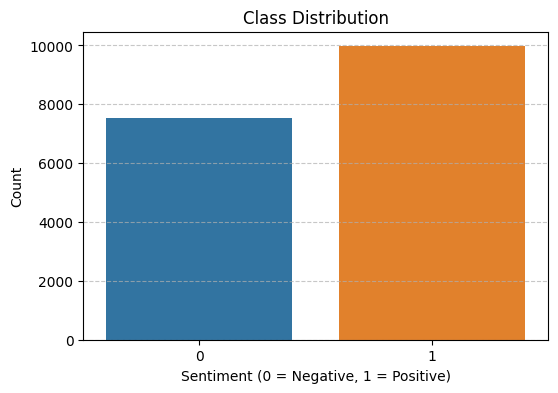

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


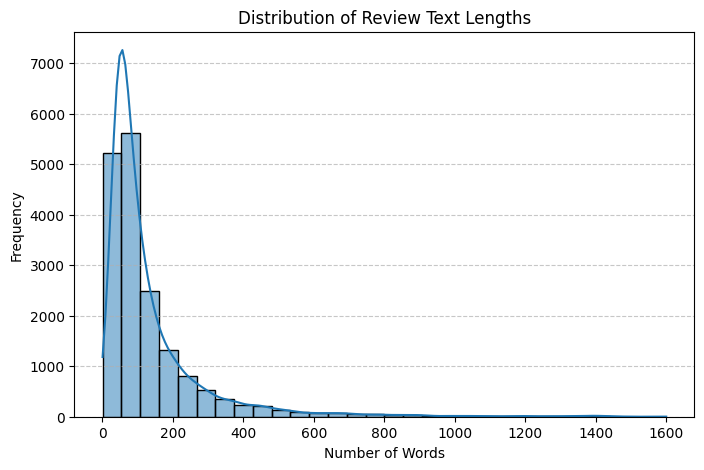

In [8]:
# Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='user_suggestion', data=df)
plt.title('Class Distribution')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Review text lengths
df['text_length'] = df['user_review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribution of Review Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

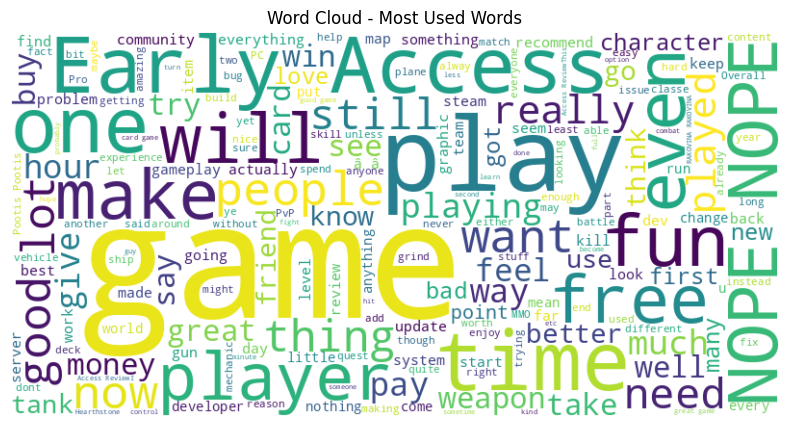

In [9]:
# WordCloud
text = ' '.join(df['user_review'])

plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Most Used Words")
plt.show()

In [10]:
def load_and_preprocess_data(file_path):
    # df = pd.read_csv(file_path)
    df['processed_text'] = df['user_review'].apply(preprocess_text)
    return df

# 2. TF-IDF Vectorization

In [11]:
def create_tfidf_features(df):
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, 
                                     ngram_range=(1,2), 
                                     min_df=2)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names, tfidf_vectorizer

# 3. Feature Analysis

In [12]:
def analyze_features(tfidf_matrix, feature_names, top_n=20):
    mean_tfidf = np.mean(tfidf_matrix.toarray(), axis=0)
    feature_scores = pd.DataFrame({
        'feature': feature_names,
        'score': mean_tfidf
    })
    top_features = feature_scores.sort_values('score', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Mean TF-IDF Score')
    plt.show()
    
    return top_features

# 4. Sentiment Analysis Models

In [13]:
def train_and_evaluate_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Naive Bayes
    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)
    nb_pred = nb_model.predict(X_test)
    nb_acc = accuracy_score(y_test, nb_pred)

    # Support Vector Machine
    svm_model = LinearSVC()
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_acc = accuracy_score(y_test, svm_pred)
    
    print("Naive Bayes Results:")
    print(classification_report(y_test, nb_pred))
    print("\nSVM Results:")
    print(classification_report(y_test, svm_pred))

    # Accuracy Comparison of Models   
    models = ['Naive Bayes', 'SVM']
    accuracies = [nb_acc, svm_acc]
    
    sns.barplot(x=models, y=accuracies)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    # Confusion Matrix and Classification Report    
    y_pred = svm_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return nb_model, svm_model, nb_acc, svm_acc, X_test, y_test

# 5. Prediction Function

In [14]:
def predict_new_review(review_text, tfidf_vectorizer, model):
    processed_review = preprocess_text(review_text)
    tfidf_review = tfidf_vectorizer.transform([processed_review])
    prediction = model.predict(tfidf_review)
    return prediction[0]

# Main execution

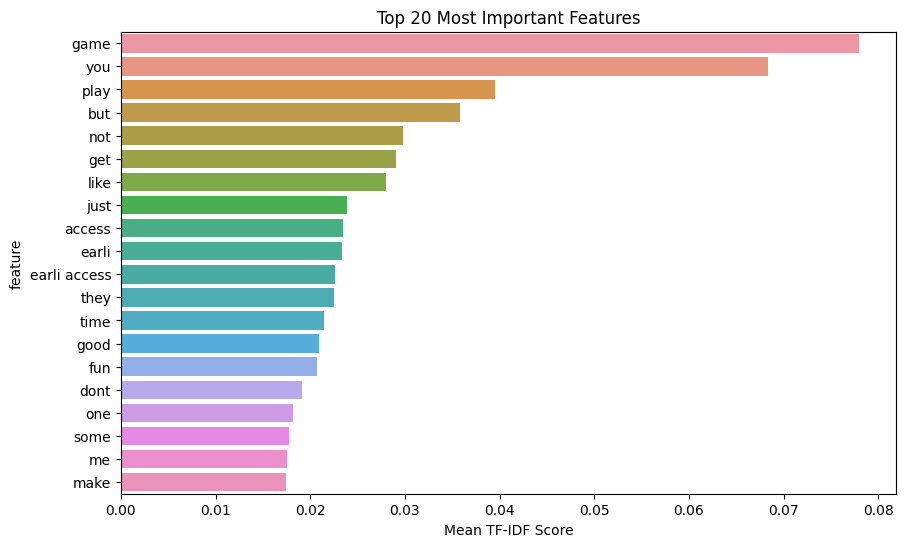


Top Features:
           feature     score
1499          game  0.077965
4822           you  0.068372
3217          play  0.039527
454            but  0.035777
2923           not  0.029838
1766           get  0.029021
2430          like  0.028024
2266          just  0.023855
14          access  0.023456
1078         earli  0.023382
1079  earli access  0.022587
4237          they  0.022512
4337          time  0.021450
1867          good  0.020876
1477           fun  0.020730
1000          dont  0.019103
3014           one  0.018131
3904          some  0.017704
2646            me  0.017533
2577          make  0.017460
Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1473
           1       0.85      0.90      0.87      2026

    accuracy                           0.85      3499
   macro avg       0.85      0.84      0.84      3499
weighted avg       0.85      0.85      0.85      3499


SVM Results:
              

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


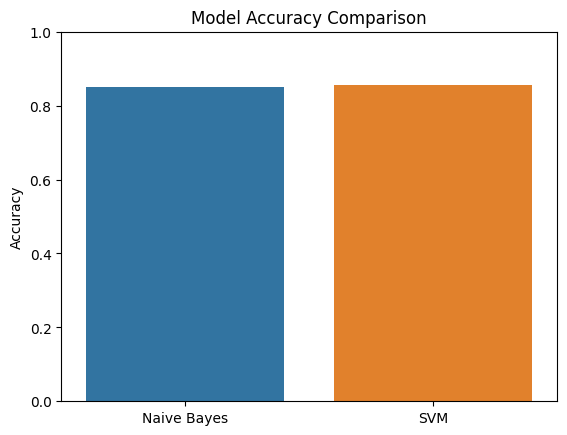

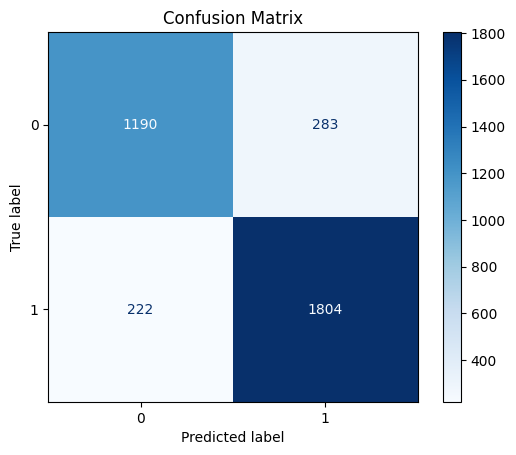

In [ ]:
def main():
    file_path = '/Steam_Reviews_Dataset/archive/train_gr/train.csv'
    df = load_and_preprocess_data(file_path)
    
    tfidf_matrix, feature_names, tfidf_vectorizer = create_tfidf_features(df)
    top_features = analyze_features(tfidf_matrix, feature_names)
    print("\nTop Features:")
    print(top_features)
    
    X = tfidf_matrix
    y = df['user_suggestion']
    # nb_model, svm_model = train_and_evaluate_models(X, y)
    nb_model, svm_model, nb_acc, svm_acc, X_test, y_test = train_and_evaluate_models(X, y)
    
    return tfidf_vectorizer, svm_model

if __name__ == "__main__":
    tfidf_vectorizer, svm_model = main()

In [16]:
# Example usage of prediction
new_review = "This game is absolutely amazing!"
prediction = predict_new_review(new_review, tfidf_vectorizer, svm_model)
print(f"\nAdditional Prediction - Review: '{new_review}'")
print(f"Predicted sentiment: {prediction} (1 = positive, 0 = negative)")


Additional Prediction - Review: 'This game is absolutely amazing!'
Predicted sentiment: 1 (1 = positive, 0 = negative)


In [17]:
# Example usage of prediction
new_review = "This game is trash."
prediction = predict_new_review(new_review, tfidf_vectorizer, svm_model)
print(f"\nAdditional Prediction - Review: '{new_review}'")
print(f"Predicted sentiment: {prediction} (1 = positive, 0 = negative)")


Additional Prediction - Review: 'This game is trash.'
Predicted sentiment: 0 (1 = positive, 0 = negative)


In [18]:
# Example usage of prediction
new_review = "This game is truely not played in sportsman spirit, its awful."
prediction = predict_new_review(new_review, tfidf_vectorizer, svm_model)
print(f"\nAdditional Prediction - Review: '{new_review}'")
print(f"Predicted sentiment: {prediction} (1 = positive, 0 = negative)")


Additional Prediction - Review: 'This game is truely not played in sportsman spirit, its awful.'
Predicted sentiment: 0 (1 = positive, 0 = negative)


# Additional Test Sentences

In [19]:
# Testing with new review examples
sample_reviews = [
    "I absolutely loved playing this game, it is very good!",
    "The graphics were terrible and the story made no sense.",
    "A fun and addictive game, totally worth the time.",
    "It crashes every time I open it. Worst experience ever.",
    "One of the best games I've played in a long time!",
    "The game is okay but gets boring quickly.",
    "Very innovative gameplay and smooth performance.",
    "Too many bugs to even play. Avoid at all costs.",
    "The soundtrack is beautiful and the missions are exciting.",
    "Not impressed. Feels like an unfinished product.",
]
for review in sample_reviews:
    pred = predict_new_review(review, tfidf_vectorizer, svm_model)
    print(f'Review: {review}\nPredicted Sentiment: {"Positive" if pred == 1 else "Negative"}\n')

Review: I absolutely loved playing this game, it is very good!
Predicted Sentiment: Positive

Review: The graphics were terrible and the story made no sense.
Predicted Sentiment: Negative

Review: A fun and addictive game, totally worth the time.
Predicted Sentiment: Positive

Review: It crashes every time I open it. Worst experience ever.
Predicted Sentiment: Negative

Review: One of the best games I've played in a long time!
Predicted Sentiment: Positive

Review: The game is okay but gets boring quickly.
Predicted Sentiment: Positive

Review: Very innovative gameplay and smooth performance.
Predicted Sentiment: Positive

Review: Too many bugs to even play. Avoid at all costs.
Predicted Sentiment: Negative

Review: The soundtrack is beautiful and the missions are exciting.
Predicted Sentiment: Positive

Review: Not impressed. Feels like an unfinished product.
Predicted Sentiment: Negative

